# 列联表


In [1]:
wid <- matrix(c(10,7,6,12,8,13),3)
shop <- matrix(c(83, 91, 41, 70, 86, 38, 45, 15, 10),3)

## 齐性问题

对于几种处理方式，它们都产生值域相同的离散结果。也就是说，它们是相同support的离散随机变量，一次抽样分别指定其内部抽样规模为$n_1,\dots,n_m$。
则可以一次抽样结果可以展现为一列联表。如

In [4]:
shop

83,70,45
91,86,15
41,38,10


In [5]:
apply(shop,1,sum)

[1] 198 192  89

这里可以是一次三个处理分别投入子规模为$198,192,89$的抽样结果。

我们对于检验几个处理是否同分布很感兴趣，这就是齐性问题。

既然实际上是检验几个样本是否同分布问题，我们当然可以试图利用KS检验，Pearson拟合优度检验之类的分布拟合优度检验。
然而我们发现并没有可以直接用的多样本的同分布检验，不像位置和尺度有这种检验。直接分别做多次两两比较显然会导致显著性水平不可控制地上升。
而且说白了我也只知道KS检验可以检验两样本是否同分布，然而这货要求连续，也根本不适用这里的情况。

我们也可以试图凭空构造一些统计量，比如先求出各个内部的观测频率，再加权得到总平均频率，算各个格对其的对应平方和。拒绝域可以划到比较大值的情况，
显然它满足power在原假设低在备择假设上低的性质。然而这么凭空扯淡当然无法得出该统计量的分布，更不知道这个分布是不是和参数组合相关的。
如果相关的话，我们就不能直接检验它们相等的假设，而必须检验相等于一个特定值的假设，这显然太虚弱了。

不妨真的试一下看看，下面构造子样本规模分别为$198,192,89$，概率为几个特定值的总体，模拟其统计量分布。

In [6]:
size <- c(198,192,89)
p <- c(0.2,0.3,0.5)


In [9]:
rmultinom(10, 198, p)

34,36,45,45,27,28,41,36,32,33
59,60,53,69,77,63,56,62,61,60
105,102,100,84,94,107,101,100,105,105


In [14]:
rtable <- function(size, p){
    m <- length(size)
    n <- length(p)
    mat <- matrix(rep(NA,m * n), m)
    for(i in 1:m){
        mat[i,] <- t(rmultinom(1, size[i], p))
    }
    return(mat)
}

In [28]:
rough.stat <- function(mat){
    freq <- mat / apply(mat,1,sum)
    prob <- apply(mat,2,sum)/sum(mat)
    sum(sweep(freq,2,prob)^2)
}

In [34]:
rough.stat(rtable(size,p))

[1] 0.002156392

In [36]:
t1 <-  rtable(size,c(0.8,0.1,0.1))
t2 <-  rtable(size,c(0.1,0.8,0.1))
t3 <-  rtable(size,c(0.1,0.1,0.8))

tt <- rbind(t1[1,],t2[2,],t3[3,])
tt

164,19,15
24,152,16
11,5,73


In [58]:
s <- replicate(1000, rough.stat(rtable(size,p)))

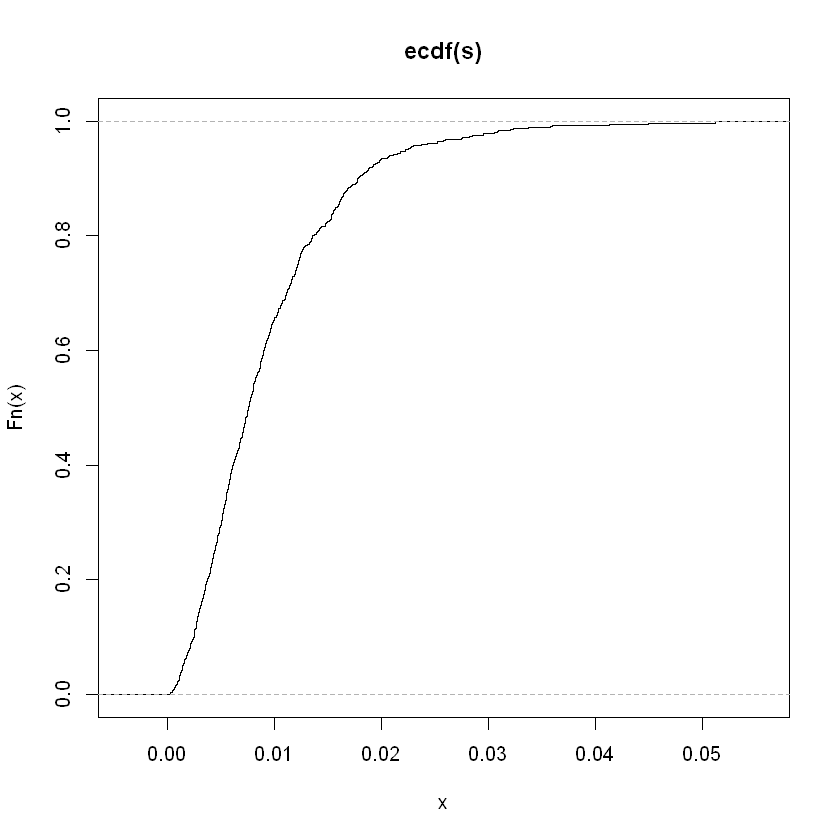

In [55]:
plot(ecdf(s))

In [41]:
p2 <- c(0.5, 0.2, 0.3)

s2 <- replicate(1000, rough.stat(rtable(size,p2)))

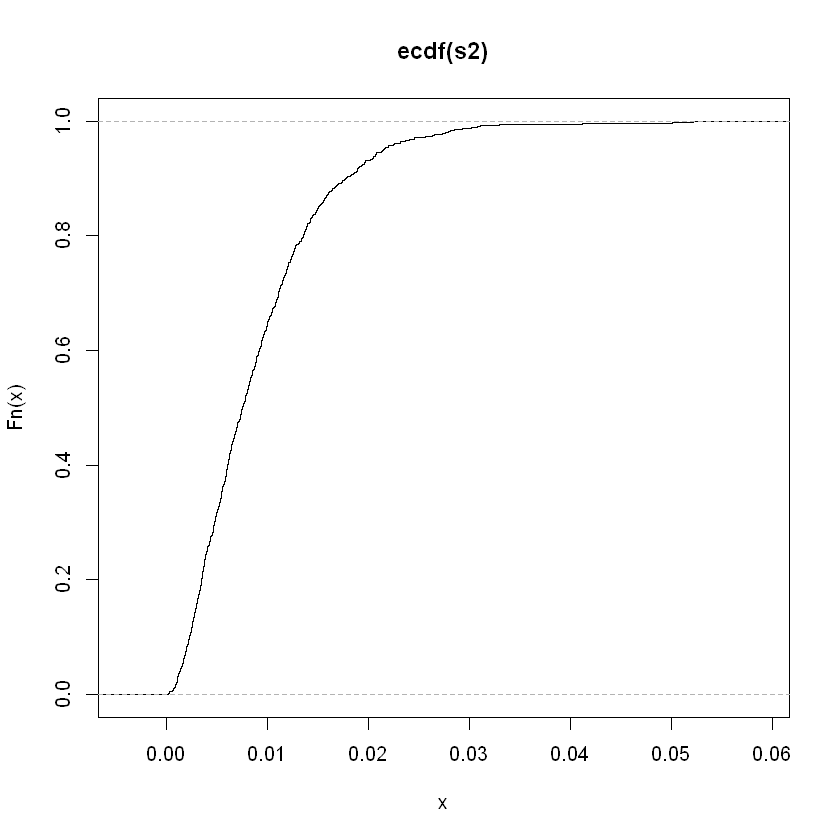

In [43]:
plot(ecdf(s2))

In [45]:
ks.test(s,s2)


	Two-sample Kolmogorov-Smirnov test

data:  s and s2
D = 0.038, p-value = 0.4658
alternative hypothesis: two-sided


看上去貌似还真有可能是同分布的。看看不满足时的功效

In [81]:
alpha <- 0.05
ecdf.s <- ecdf(s)
ss <- sort(s)
idx <- which(ecdf.s(ss) > 1-alpha)[1]
border <- ss[idx]
border

[1] 0.0248735

In [82]:
ecdf.s(border)

[1] 0.951

In [83]:
rtable.chaos <- function(size, pp){
    m <- length(size)
    n <- length(p)
    mat <- matrix(rep(NA,m * n), m)
    for(i in 1:m){
        mat[i,] <- t(rmultinom(1, size[i], pp[i,]))
    }
    return(mat)
}

In [85]:
pp <- matrix(c(c(0.8,0.1,0.1),c(0.1,0.8,0.1),c(0.1,0.1,0.8)),3)

pp

0.8,0.1,0.1
0.1,0.8,0.1
0.1,0.1,0.8


In [87]:
rtable.chaos(size, pp)

164,17,17
25,151,16
10,12,67


In [88]:
s3 <- replicate(1000, rough.stat(rtable.chaos(size, pp)))

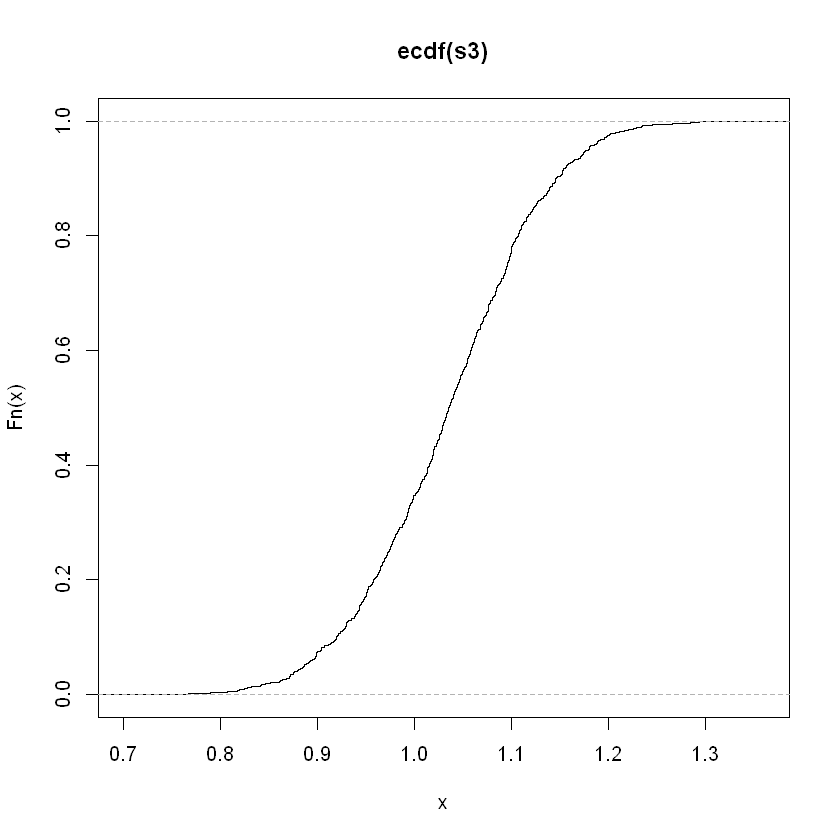

In [89]:
plot(ecdf(s3))

看上去是1的功效，很好。如果区别不是那么大呢。

In [90]:
pp <- matrix(c(c(0.4,0.3,0.2),c(0.3,0.4,0.2),c(0.2,0.3,0.4)),3)

pp

0.4,0.3,0.2
0.3,0.4,0.3
0.2,0.2,0.4


In [91]:
s3 <- replicate(1000, rough.stat(rtable.chaos(size, pp)))

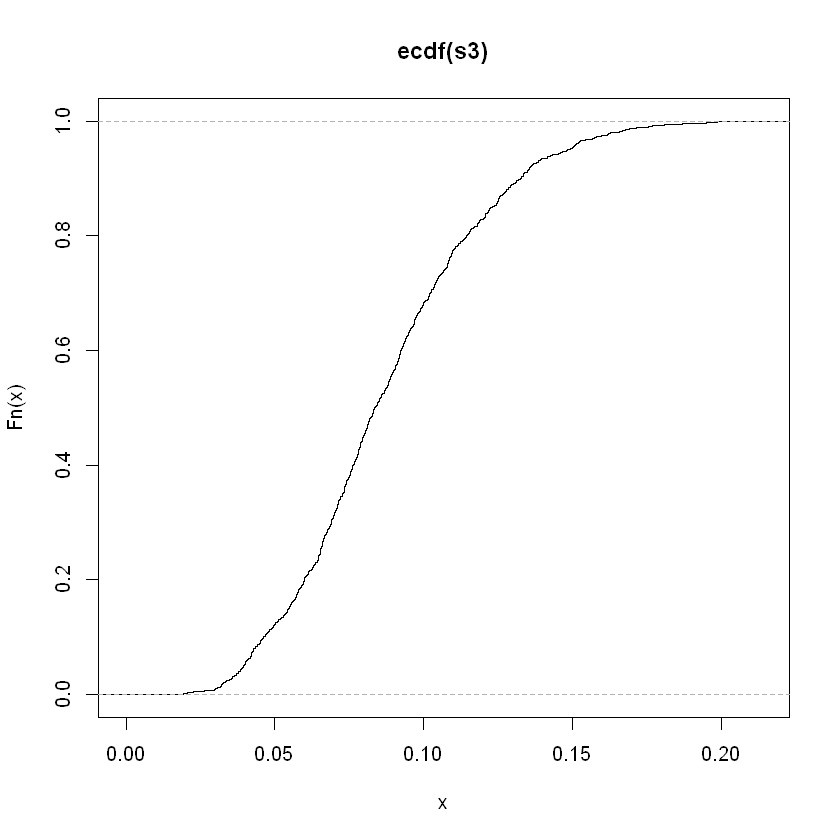

In [92]:
plot(ecdf(s3))

In [93]:
mean(s3 > border)

[1] 0.994

0.994的功效。

In [94]:
pp <- matrix(c(c(0.35,0.3,0.35),c(0.3,0.35,0.35),c(0.35,0.35,0.3)),3)

pp

0.35,0.30,0.35
0.30,0.35,0.35
0.35,0.35,0.30


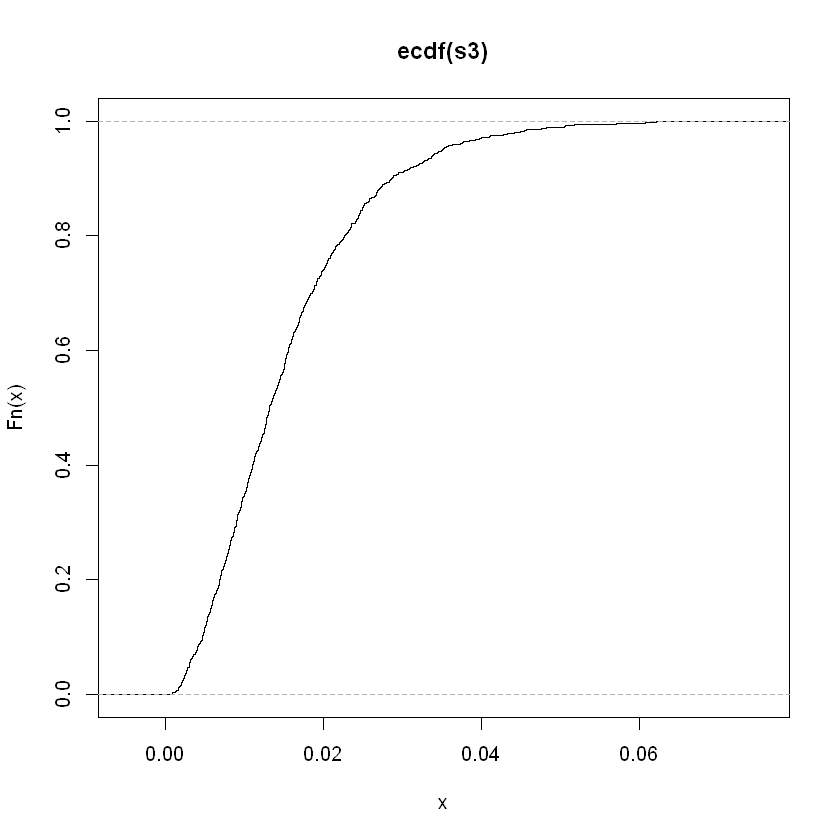

In [95]:
s3 <- replicate(1000, rough.stat(rtable.chaos(size, pp)))
plot(ecdf(s3))

In [96]:
mean(s3 > border)

[1] 0.155

区别小到最多0.05的水平的时候，这个各子样本规模设定就识别不出来这种微小的差别了。

看上去还不错，看看这个统计量形式地表达出来是怎么回事

$$
\sum_{i=1}^r \sum_{j=1}^c \left( \frac{n_{ij}}{n_{i.}} - \frac{n_{.j}}{n_{..}} \right)^2
=
\frac{1}{n_{i.}^2} \sum_{i=1}^r \sum_{j=1}^c \left( {n_{ij}} - \frac{n_{i.} n_{.j}}{n_{..}} \right)^2
$$

很荣幸，这与有名的Pearson $\chi^2$统计量只有标准化方法上的差异。

$$
Q = \frac{\sum_{i=1}^r \sum_{j=1}^c \left( {n_{ij}} - \frac{n_{i.} n_{.j}}{n_{..}} \right)^2}
{\frac{n_{i.}n_{.j}}{n_{..}}}
$$

它在原假设成立下有

$$
Q \sim \chi^2((r-1)(s-1))
$$

的确，既然它与分配概率无关，又只与我的统计量有尺度差别。则我的统计量也自然是与分配概率无关的，同样性质优良。

从这个还可以看出一点，即齐性检验实际上可以用作检验离散多样本是否同分布的方法，如果几个离散样本的值域并不能对齐，可以补上0格。
当然实际并不推荐出现0格，这时也可以考虑抹掉一些信息，合并一些取值。

## 齐性检验和独立性检验的本质区别与统计检验上的等价性

齐性检验赋予的随机模型是给定几个$n_i$规模子样本。其中各个子样本的$p_i$可以是不同的，零假设是各$p_i = p$相等。

独立性检验赋予的随机模型是给定规模为$n$的总样本，看它们落到双变量的哪些格中去了。每个格都有一个概率，零假设是限制这些概率表示为列和乘积形式。

它们的基础都是多项分布。不过它们的随机模型有本质区别。然而由于一些类似性，它们的统计量却是一样的，也服从一样的分布。如似然比检验。

对于齐性检验来说，我们可以试图在对$p_i$无约束和约束它们为$p=p_i$的假设空间中以样本求其极大似然估计量$p$，
然后看样本在在此估计量为参数时的似然比。这个似然比统计量虽然涉及最优化，其实比看上去好算。显然它的无约束最优参数就是子样本内部的比例，
而有约束最优参数就是整体比例。再按其计算概率即可

$$
L_1 = C \frac{n_{.1}}{n_{..}}^{n_{.1}} \dots \frac{n_{.c}}{n_{..}}^{n_{.c}} = C \prod_{j=1}^c \frac{n_{.j}}{n_{..}}^{n_{.j}} 
= C \prod_{ij} \frac{n_{.j}}{n_{..}}^{n_{ij}}
\\
L_2 = C (\frac{n_{11}}{n_{1.}}^{n_{11}} \dots \frac{n_{1c}}{n_{1.}}^{n_{1c}}) \dots ( \frac{n_{r1}}{n_{r.}}^{n_{r1}} \dots \frac{n_{rc}}{n_{r.}}^{n_{rc}} )
= C \prod_{ij} \frac{n_{ij}}{n_{i.}}^{n_{ij}} \\
LRT = \frac{L_1}{L_2} = \frac{1}{n_{..}^{n_{..}}} \prod_{ij} \frac{n_{i.}n_{.j}}{n_{ij}}^{n_{ij}}
$$


而独立性的无约束最优参数都是观测频率，有约束最优显然是行列和频率。
有趣的是，虽然$L_1,L_2$的定义在齐性和独立性检验中是不一样的，但它们的比，$LRT$统计量却是一样的。

$$
L_1 = C \prod_{ij} \frac{n_{i.}n_{.j}}{n_{..}^2}^{n_{ij}} \\
L_2 = C \prod_{ij} \frac{n_{ij}}{n_{..}}^{n_{ij}} \\
LRT = \frac{1}{n_{..}^{n_{..}}} \prod_{ij} \frac{n_{i.}n_{.j}}{n_{ij}}^{n_{ij}} 
$$

$$
\log LRT = -n_{..}\log n_{..} + \sum_{ij} n_{ij} \log( \frac{n_{i.}n_{.j}}{n_{ij}} )
$$

LRT在经过一些对数和其他标准化后有与Pearson统计量一样的渐进分布$\chi^2((r-1)(c-1))$。
似然比统计量渐进分布的自由度由“有效的”（符合一堆正则条件）无约束参数空间维数减有约束参数空间维数得到。从齐性检验出发的话，无约束空间有
$r(c-1)$维（虽有$rc$个参数，但受到了$r$个线性约束。），有约束空间有$c-1$维(虽有$c$个参数，但受到$1$个线性约束)。
则$rc - r - c + 1 = (r-1)(c-1)$。从独立性检验出发的话，无约束空间有$rc - 1$维，
有约束空间有$ r - 1 + c - 1$维。则$rc - 1 - r + 1 - c + 1 = (r-1)(c-1)$。结果一致。


## 部分条件化

### Fisher精确检验

上面的Pearson与LRT检验统计量服从卡方分布其实都是渐进结果。对于$2 \times 2$列联表我们可以如此求出简单的精确分布。

从齐性检验出发，设定规模为$n_1$与$n_2$的子样本互相独立，且其分配到第一类分别为$p_1,p_2$则抽出一个特定列联表形式的概率为

$$
P\left( 
\begin{bmatrix}
x_1 & n_1 - x_1 \\
x_2 & n_2 - x_x
\end{bmatrix}
\right)
=
\begin{pmatrix} n_1 \\ x_1 \end{pmatrix}
p_1^{x_1} (1-p_1)^{n_1 - x_1}
\begin{pmatrix} n_2 \\ x_2 \end{pmatrix}
p_2^{x_2} (1-p_2)^{n_2 - x_2}
$$

上面是元假设，在原假设$p_1 = p_2 = p$下有

$$
P\left( 
\begin{bmatrix}
x_1 & n_1 - x_1 \\
x_2 & n_2 - x_x
\end{bmatrix}
\right)
=
\begin{pmatrix} n_1 \\ x_1 \end{pmatrix}
\begin{pmatrix} n_2 \\ x_2 \end{pmatrix}
p^{x_1 + x_2} (1 - p)^{N - x_1 - x_2}
$$

到目前的为止得到的这些并没有什么帮助，即使是给定特定$p = p_1 = p_2$这种特别简单的假设（$p$值给定了），并由上式得到了确定抽样分布，又怎么样呢？
我们并没有工具评价对于一个样本表对于这个分布是不是看起来不太可能生成那样的样本，因为我们没法定义p值或合理的拒绝域。

可以考虑进一步构造统计量，就像依附初级统计量分布函数的P值统计量一样。比如我们可以只考虑左上角那个格，对于给定的$p_1,n_1$，
可以设其过于偏离其期望值的取值为拒绝域。这相当于做了个局部参数检验。我们可以尝试合并这样的检验来达成我们所有$p_1 = p_2$的原假设类似，
在备择假设上则不然的统计量，如交并方法，但看起来还能更简单一些。

事实上第一列和取值$c$的概率为

$$
P(c) = \begin{pmatrix} N \\ c \end{pmatrix} p^c (1-p)^{N-c}
$$

(这里和上面均省去随机变量等于多少的写法，无伤大雅)

于是在原假设下，给定列和为$c$的条件下，出现一个特定表或出现特定$x_1$的条件概率为

$$
P\left( 
\begin{bmatrix}
x_1 & n_1 - x_1 \\
x_2 & n_2 - x_x
\end{bmatrix}
\mid
c
\right)
=
\begin{pmatrix} n_1 \\ x_1 \end{pmatrix}
\begin{pmatrix} n_2 \\ x_2 \end{pmatrix}
p^{x_1 + x_2} (1 - p)^{N - x_1 - x_2}
\frac{1}{\begin{pmatrix} N \\ c \end{pmatrix} p^c (1-p)^{N-c}}
=
\frac{
\begin{pmatrix} n_1 \\ x_1 \end{pmatrix}
\begin{pmatrix} n_2 \\ c - x_1 \end{pmatrix}
}{
\begin{pmatrix} N \\ c \end{pmatrix}
}
$$

在备择假设上的第一列和为$c$的条件下统计量$x_1$将自然不服从此分布，如果$p_1 > p_2$，$x_1$将偏大，反之则偏小，
故以上述分布划定两边极端取值的拒绝域是有功效的。

我们感兴趣的的是这与可能的使用LRT之类的不需要条件化的统计量的统计推断结论有什么区别。

这里的出发点是齐性检验，如果我们在LRT之类中拒绝了原假设。是说：

在给定样本是以子样本规模为$n_1,n_2$的，划分到1列的概率分别为$p_1,p_2$的模型生成的元假设下，统计地推断$p_1$与$p_2$是不同的。

由于齐性与独立性检验在计算上是等价的，我们还被附送了以下结论：

在给定样本是以总规模为$n_1 + n_2$，分配到各格概率分别为$p_{11},p_{12},p_{21},p_{22}$的模型生成的元假设下，
统计地推断四个概率参数不能被（独立性）限制的形式表达。或者说两变量起作用不独立

而齐性检验上的Fisher精确检验，若得出拒绝结果则有以下结论：

在给定样本是以子样本规模为$n_1,n_2$，划分到1列的概率分别为$p_1,p_2$的模型生成，且给出第一行和为$c$的条件概率下的元假设下，
统计地推断$p_1$与$p_2$是不同的。

看上去这种固定列和是在元假设上是一种更弱的检验，特别在$c$取得与样本的$c$不一致的情况下。这个还带给元假设直观一个挑战，
当同一个数据被以不同元假设建立不同的随机模型，然后得出不相关的统计推断时，这一点并不明显。
但这里元假设进行的修改是如此的微妙，使得结论如何区分也令人费解了。

对于一个样本，我们给它们一些从元假设上就不合理的随机模型上，当然无论如何都会拒绝原假设。这并没有错，因为所有假设检验都是个
“如果元假设对（随机模型恰当），则原假设（统计意义）假”实质蕴含式推理，因为元假设假，所以后面的命题就没有意义了。

那么这里的问题就是，固定某列和，或者在一个检验中对某些量条件化，这种在元假设上的修改得到一个新假设检验，是否是合理的。
这种条件化一般对一个自然的可以生成样本的随机模型下手，将其中一些本来包含在联合分布的变量或统计量按照观测样本固定，对其余变量条件化。
比如我们可以试想一个多元正态期望向量的检验，元假设构造了$n$样本规模的一个多元正态分布的随机模型，
但有一个条件化版本将其中$n/2$个元按样本都固定了，其余变量和统计量变为它们的条件分布。这合理吗？

下面构造一个例子，就是检验多元正态分布均值。分块记号为

$$
X = \begin{bmatrix} X^{(1)} \\ X^{(2)} \end{bmatrix} \\
\mu = \begin{bmatrix} \mu^{(1)} \\ \mu^{(2)} \end{bmatrix} \\
\Sigma = \begin{bmatrix} \Sigma_{11} & \Sigma_{12} \\ \Sigma_{21} & \Sigma_{22} \end{bmatrix}
$$

其中$X^{(1)}$为$q \times 1$维，$\Sigma_{11}$为$q \times q$维。$\Sigma$为$p \times p$维。

对$X \sim N_p(\mu,\Sigma)$

$$
(X^{(1)} \mid X^{(2)}) \sim N_q(\mu_{1 . 2},\Sigma_{11 . 2})
$$

其中

$$
\mu_{1.2} = \mu^{(1)} + \Sigma_{12}\Sigma_{22}^{-1}(X^{(2)} - \mu^{(2)}) \\
\Sigma_{11.2} = \Sigma_{11} - \Sigma_{12}\Sigma_{22}^{-1}\Sigma_{21}
$$

$.$表示左边的元是之前的元，但被右边所条件化。

In [56]:
mu <- c(154.98, 83.39, 70.26, 61.32, 91.52)
Sigma.v <- c(29.66, 6.51, 1.85, 9.36, 10.34, 30.53, 25.54, 3.54, 19.53, 39.86, 2.23, 20.70, 7.03, 5.21, 27.36)

In [68]:
Sigma <- matrix(NA,5,5)

In [69]:
k <- 1
for(j in 1:5){
    for(i in j:5){
        Sigma[i,j] <- Sigma.v[k]
        k <- k+1
    }
}
Sigma[is.na(Sigma)] <- t(Sigma)[is.na(Sigma)]

In [59]:
mu

[1] 154.98  83.39  70.26  61.32  91.52

In [73]:
Sigma

29.66,6.51,1.85,9.36,10.34
6.51,30.53,25.54,3.54,19.53
1.85,25.54,39.86,2.23,20.70
9.36,3.54,2.23,7.03,5.21
10.34,19.53,20.70,5.21,27.36


In [74]:
cnorm <- function(mu, Sigma, cond){
    # cond is same shape as mu, and include NA to indicate what numer is reseve.
    s1 <- which(is.na(cond))
    s2 <- which(!is.na(cond))
    mu1 <- mu[s1]
    mu2 <- mu[s2]
    Sigma11 <- Sigma[s1,s1]
    Sigma12 <- Sigma[s1,s2]
    Sigma21 <- Sigma[s2,s1]
    Sigma22 <- Sigma[s2,s2]
    X2 <- cond[s2]
    
    mu.cond <- mu1 + Sigma12 %*% solve(Sigma22) %*% (X2 - mu2)
    Sigma.cond <- Sigma11 - Sigma12 %*% solve(Sigma22) %*% Sigma21
    return(list(mu = mu.cond, Sigma = Sigma.cond, index = is.na(cond)))
}

In [78]:
cnorm(mu,Sigma, c(NA,NA,NA,NA,mu[5]))

$mu
       [,1]
[1,] 154.98
[2,]  83.39
[3,]  70.26
[4,]  61.32

$Sigma
           [,1]       [,2]      [,3]       [,4]
[1,] 25.7522661 -0.8708553 -5.973026  7.3910161
[2,] -0.8708553 16.5891776 10.764013 -0.1789803
[3,] -5.9730263 10.7640132 24.198816 -1.7117763
[4,]  7.3910161 -0.1789803 -1.711776  6.0378911

$index
[1]  TRUE  TRUE  TRUE  TRUE FALSE

这里搞一个比较简单的检验，设$\Sigma$已知，我们想检验期望向量是否是正确的，对于样本规模$n$，可给定

$$
\sum_{i=1}^n (X_i-\mu)^T\Sigma^{-1}(X_i-\mu) \sim \chi^2(np)
$$

先看看这个是不是对的

In [79]:
rmultinorm <- function(n,mu,Sigma){
    res <- eigen(Sigma)
    Lambda <- diag(res$values)
    P <- res$vectors
    r <- replicate(n,as.vector( P %*% Lambda^(1/2) %*% rnorm(length(mu))) + mu)
    return(r)
}


In [84]:
sam <- rmultinorm(30, mu, Sigma)
solve.Sigma <- solve(Sigma)
sam2 <- c()
for(i in 1:ncol(sam)){
    sam2[i] <- (sam[,i] - mu) %*% solve.Sigma %*% (sam[,i] - mu)
}

In [85]:
sam2

[1] 10.025042  4.344771  2.487182  2.656547  1.256647  1.567641  6.480793
 [8]  2.705200  6.437916  2.353854  8.732457  5.263312 14.081709 12.557154
[15]  6.699555  2.223309  6.732213  2.159412  2.775863  3.448897  4.084433
[22]  4.303392  2.500258  5.949064 10.277591 10.920861  1.960589  3.527395
[29]  4.291763  2.960675

In [120]:
stat <- function(sam, mu, Sigma, solve.Sigma = NA){
    if(!is.matrix(solve.Sigma)){
        solve.Sigma <- solve(Sigma)
    }
    sam2 <- c()
    for(i in 1:ncol(sam)){
        sam2[i] <- (sam[,i] - mu) %*% solve.Sigma %*% (sam[,i] - mu)
    }
    return(sum(sam2))
}

In [125]:
experiment <- function(mu, Sigma, n, size = 100){
    sam <- rmultinorm(n*size, mu, Sigma)
    solve.Sigma <- solve(Sigma)
    sam3 <- c()
    for(i in 1:size){
        sam3[i] <- stat(sam[,(i*n-n+1):(i*n)], mu, Sigma, solve.Sigma = solve.Sigma)
    }
    return(sam3)
}

In [126]:
sam <- experiment(mu,Sigma, 30)

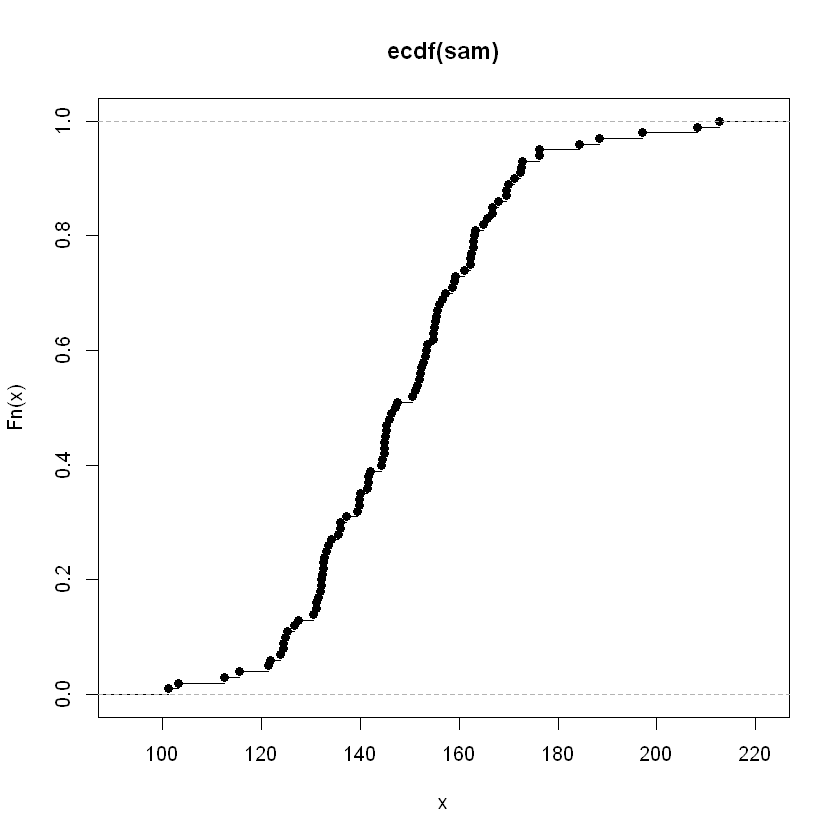

In [127]:
plot(ecdf(sam))

In [128]:
ks.test(sam,pchisq,5*30)


	One-sample Kolmogorov-Smirnov test

data:  sam
D = 0.088868, p-value = 0.4086
alternative hypothesis: two-sided


In [141]:
pchisq(stat(rmultinorm(30, mu - rep(3,5),Sigma), mu,Sigma),5*30,low=F)

[1] 0.001735584

这个问题看来是个大坑。。先放下吧。。

## 对数线性模型

对于高维列联表，对数线性模型是独立性检验的推广。对数线性模型的随机模型是指定总样本规模$n$后，按每格独有的概率形成的多项分布分配到各格。
在层次（hierachical）模型里，每格独有概率被以不同的共有因素表示。比如完全独立模型里每格的概率由每个变量的一个水平对应的概率求积得到。

如设列联表有三个变量，每个变量个三个水平。一共27个格子的概率记为$p_{ijk}$。分布记做$\mathbf{n} \sim M(n_{...},\mathbf{m}/n_{...})$。
其中$\mathbf{1}^T\mathbf{m} = n...$只不过是$p_{ijk}$的一个记法。可以和之前的期望频数类比。

In [142]:
?loglin

In [152]:
wmq <- read.csv('wmq.csv')
xt <- xtabs(Count ~  X + Z + Y,wmq)
xt

, , Y = C

   Z
X    N  S
  A 45 43
  B 39 51
  C 54 67

, , Y = R

   Z
X    N  S
  A 66 51
  B 32 35
  C 30 32


In [153]:
loglin(xt, list(1,2,3))

2 iterations: deviation 0 


$lrt
[1] 26.56823

$pearson
[1] 27.29357

$df
[1] 7

$margin
$margin[[1]]
[1] "X"

$margin[[2]]
[1] "Z"

$margin[[3]]
[1] "Y"

In [157]:
?bkde

In [159]:
?kernel

In [163]:
x <- EuStockMarkets[,1]
k1 <- kernel("daniell", 50)  # a long moving average
k2 <- kernel("daniell", 10)  # and a short one


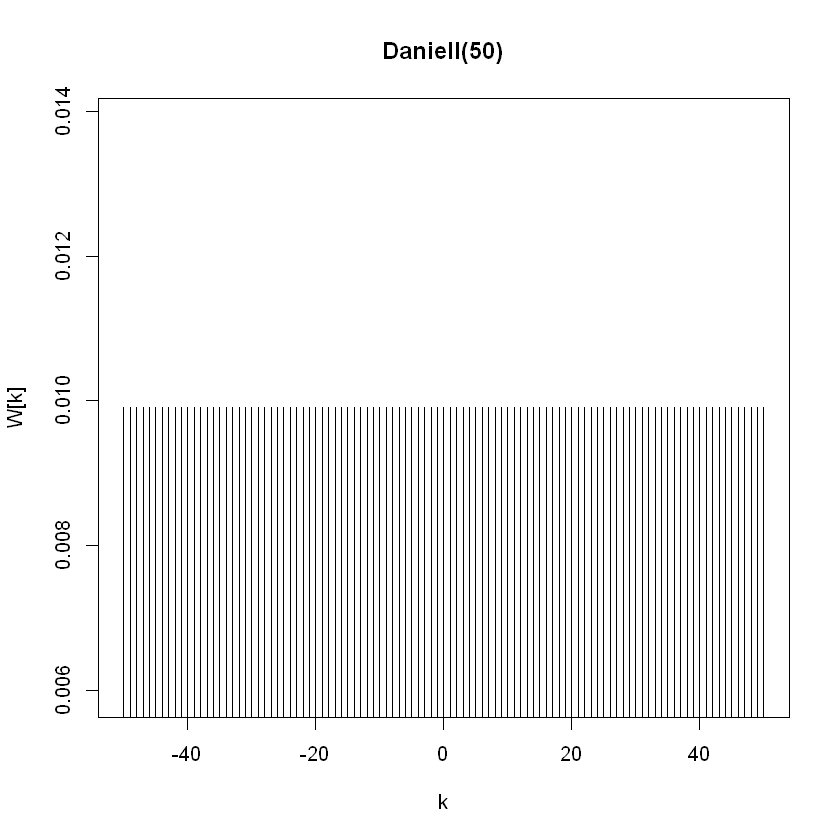

In [162]:
plot(k1)


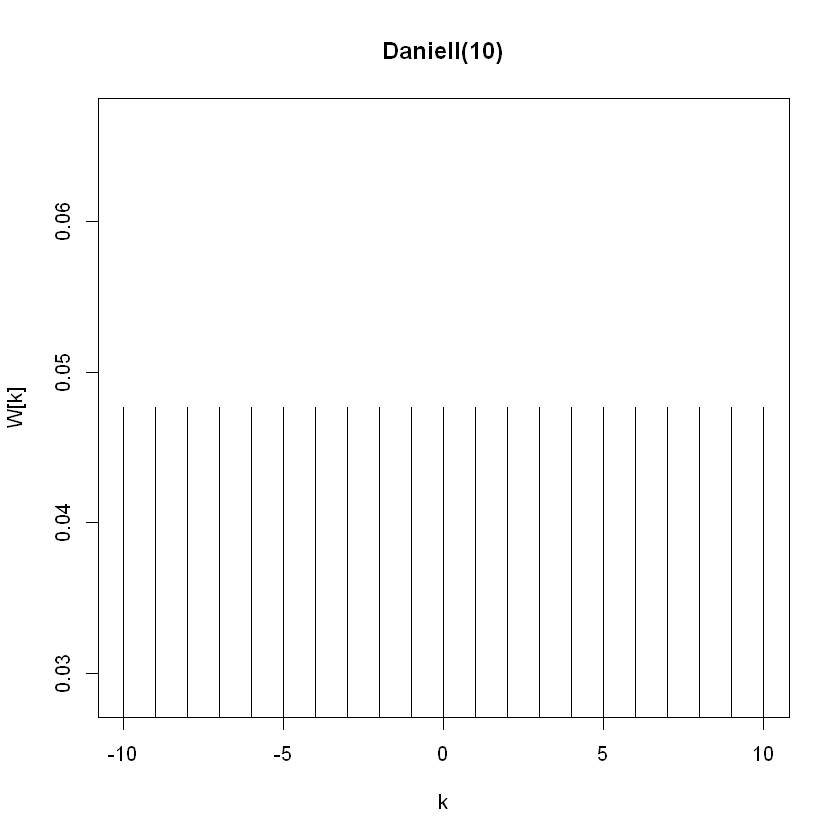

In [164]:
plot(k2)


In [166]:
str(faithful)

'data.frame':	272 obs. of  2 variables:
 $ eruptions: num  3.6 1.8 3.33 2.28 4.53 ...
 $ waiting  : num  79 54 74 62 85 55 88 85 51 85 ...
